# Marginalized Gaussian Mixture Model¶

In [69]:
import os
import sys
import time

In [70]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [148]:
import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az


In [128]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [73]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [232]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
ArviZ 0.6.1
NumPy 1.18.1
SciPy 1.4.1
Matplotlib 3.1.3



In [74]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [75]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
az.style.use('arviz-darkgrid')

%config Inline.figure_formats = ['retina']
%load_ext watermark

In [76]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PPCA'

In [77]:
%matplotlib inline

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
N = 1000
K=3
Ws = np.array([.2, .5,.3])
mus = np.array([ 0, 6, -5])
sigmas = np.array([ 1, 1.5, 3])

In [90]:
component = np.random.choice(mus.size, size=N, p=Ws)
y = np.random.normal(mus[component], sigmas[component], size=N)

In [91]:
y.shape

(1000,)

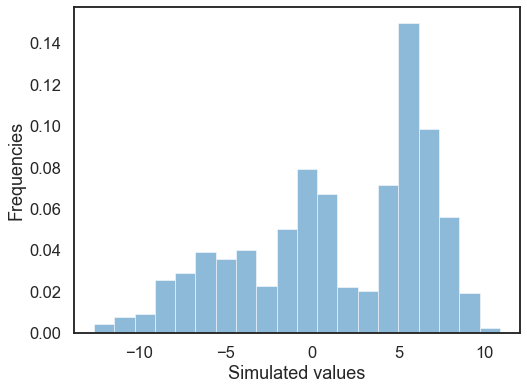

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(y, bins=20, normed=True, lw=1, alpha=0.5);

plt.xlabel('Simulated values')
plt.ylabel('Frequencies')
plt.show()

A natural parameterization of the Gaussian mixture model is as the latent variable model

\begin{split}\begin{align*}
y_i\ |\ z_i
    & \sim N(\mu_k, \sigma_k)\\   
z_i\ |\ \boldsymbol{w_k}
    & \sim \textrm{Cat}(\boldsymbol{p}) \\
\boldsymbol{p}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\    
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma') \\
\sigma_1, \ldots, \sigma_K
    & \sim \textrm{Gamma}(a, b) 
   ~~~ or~~~ \sigma_1, \ldots, \sigma_K  \sim HalfCauchy(1)\\    
\end{align*}\end{split}

In [197]:
GMM = pm.Model()

K=3

with GMM:
    p = pm.Dirichlet('p', a=np.array([1.]*K)) # Prior over z
    mu = pm.Normal('mu', mu=0., sd=10., shape=K)
    sigma = pm.HalfCauchy('sigma', beta=1., shape=K)
    #sigma = pm.Gamma('sigma', 1., 1., shape=K)
    z = pm.Categorical('z', p=p, shape=N)
    y_obs = pm.Normal('y_obs', mu=mu[z], sd=sigma[z], sigma=sigma, observed=y)

In [198]:
with GMM:
    step1 = pm.NUTS(vars=[p, mu, sigma])
    step2 = pm.ElemwiseCategorical(vars=[z])

    trace = pm.sample(draws=2000, step=[step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, mu, p]
>ElemwiseCategorical: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:54<00:00, 91.46draws/s] 
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


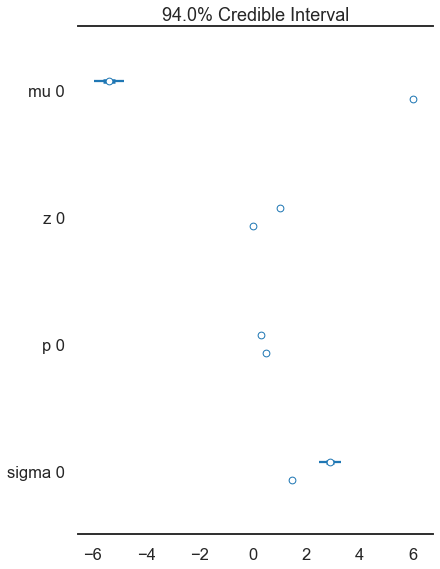

In [255]:
az.plot_forest(trace);

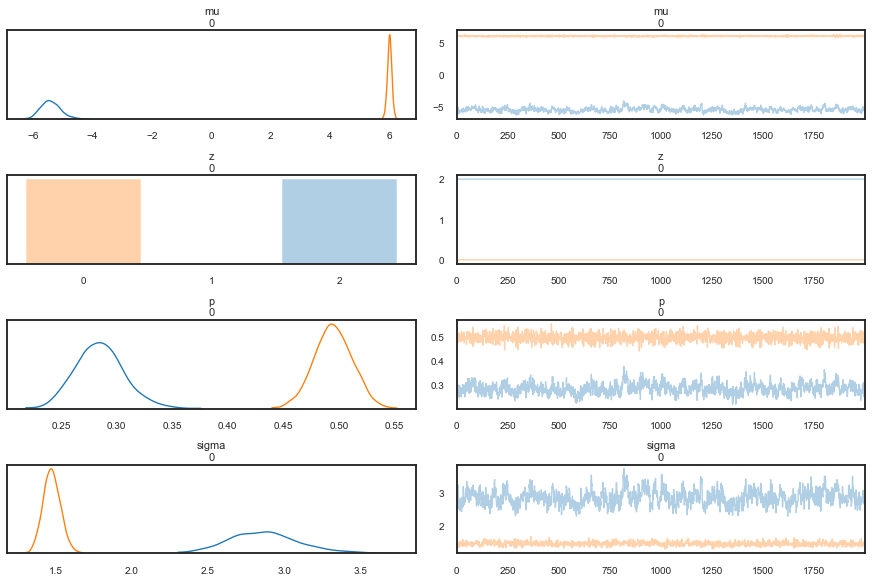

In [157]:
az.plot_trace(trace);

In [204]:
np.mean(trace['p'], axis=0)

array([0.39086859, 0.38867842, 0.22045299])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a4aea6e50>],
      dtype=object)

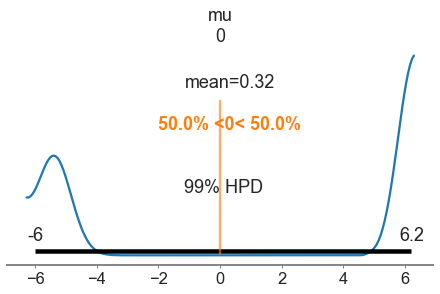

In [214]:
az.plot_posterior(trace, var_names='mu', ref_val=0, credible_interval=0.99)


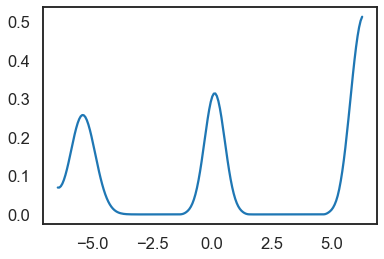

In [256]:
az.plot_kde(trace['mu']);

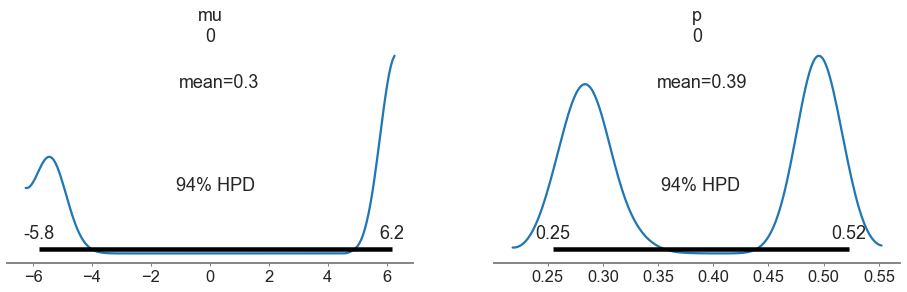

In [164]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
az.plot_posterior(trace, var_names=['mu', 'p'], ax=axes);

In [108]:
with GMM:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)

100%|██████████| 2000/2000 [00:02<00:00, 957.43it/s] 


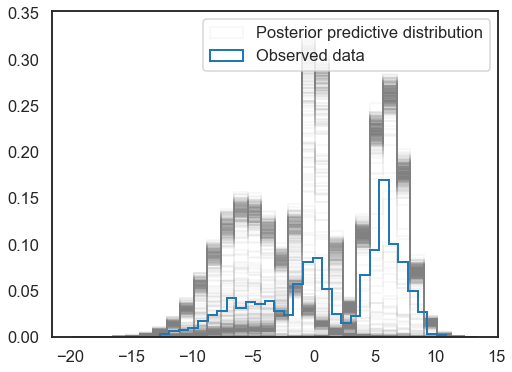

In [109]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ppc_trace['y_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['y_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(y, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [110]:
ps, np.mean(trace['p'][:], axis=0)

(array([0.2, 0.5, 0.3]), array([0.25182116, 0.35938144, 0.3887974 ]))

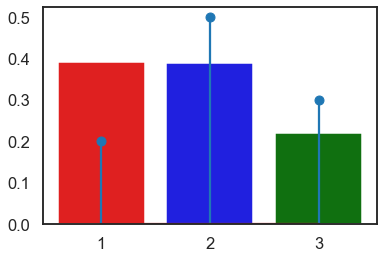

In [253]:
sns.barplot([1, 2, 3], np.mean(trace['p'][:], axis=0),palette=['red', 'blue', 'green'])
plt.stem([0, 1, 2], ps, use_line_collection=True)

plt.show()

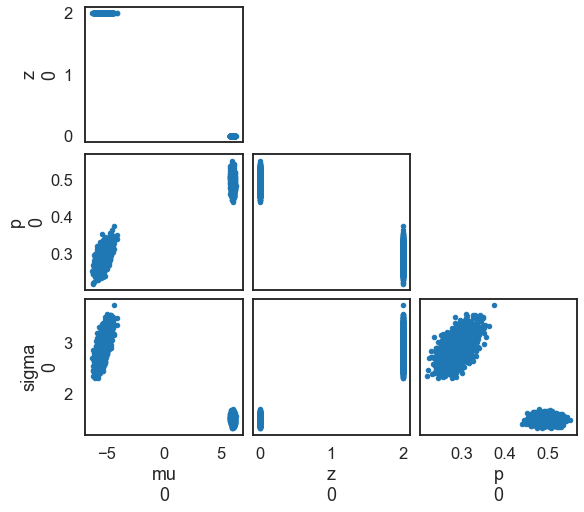

In [177]:
pm.pairplot(trace, figsize=(8, 7), divergences=True);

In [112]:
print(pm.gelman_rubin(trace,varnames=['mu','sigma','p']))

<xarray.Dataset>
Dimensions:      (mu_dim_0: 3, p_dim_0: 3, sigma_dim_0: 3)
Coordinates:
  * mu_dim_0     (mu_dim_0) int64 0 1 2
  * p_dim_0      (p_dim_0) int64 0 1 2
  * sigma_dim_0  (sigma_dim_0) int64 0 1 2
Data variables:
    mu           (mu_dim_0) float64 1.834 1.826 1.831
    sigma        (sigma_dim_0) float64 1.827 1.827 1.831
    p            (p_dim_0) float64 1.724 1.827 1.827


In [161]:
pm.summary(trace, varnames=['p']).round(3)# gives the same credible interval as in the book.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.390,0.107,0.254,0.523,0.074,0.063,2.0,2.0,3.0,58.0,1.83
p[1],0.221,0.021,0.182,0.260,0.001,0.001,394.0,392.0,395.0,698.0,1.00
p[2],0.390,0.107,0.254,0.521,0.075,0.063,2.0,2.0,3.0,60.0,1.83


In [221]:
az.rhat(trace).to_dataframe()

mu          z         p     sigma
mu_dim_0 p_dim_0 sigma_dim_0 z_dim_0                                         
0        0       0           0        1.828251  25.813440  1.830954  1.827993
                             1        1.828251        NaN  1.830954  1.827993
                             2        1.828251  16.332831  1.830954  1.827993
                             3        1.828251  36.510273  1.830954  1.827993
                             4        1.828251   1.001965  1.830954  1.827993
...                                        ...        ...       ...       ...
2        2       2           995      1.003014   1.002731  1.011404  1.009103
                             996      1.003014        NaN  1.011404  1.009103
                             997      1.003014        NaN  1.011404  1.009103
                             998      1.003014   1.001813  1.011404  1.009103
                             999      1.003014   1.001483  1.011404  1.009103

[27000 rows x 4 columns]

In [162]:
df = az.summary(trace, round_to=4)
df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],0.3025,5.7151,-5.8045,6.1716,4.0303,3.4115,2.0108,2.0108,2.9349,58.2348,1.8264
mu[1],0.0727,0.0981,-0.1109,0.2594,0.0031,0.0022,1023.9118,1023.9118,1028.5094,1455.1904,1.0006
mu[2],0.3026,5.7118,-5.7878,6.1575,4.0283,3.4100,2.0105,2.0105,2.9218,52.5379,1.8280
z[0],1.0000,1.0001,0.0000,2.0000,0.7058,0.5976,2.0080,2.0080,2.0080,2.0080,NaN
z[1],1.0005,1.0001,0.0000,2.0000,0.7050,0.5966,2.0126,2.0126,2.0126,2.0126,21.0739
...,...,...,...,...,...,...,...,...,...,...,...
p[1],0.2206,0.0207,0.1820,0.2602,0.0010,0.0007,393.7366,391.8896,394.7132,698.3554,1.0014
p[2],0.3897,0.1072,0.2543,0.5211,0.0747,0.0630,2.0561,2.0526,2.9204,59.7955,1.8277
sigma[0],2.1692,0.7158,1.3547,3.1558,0.4942,0.4144,2.0980,2.0980,2.9354,51.9678,1.8280
sigma[1],1.0536,0.0905,0.8879,1.2301,0.0047,0.0034,365.1910,360.7938,374.3138,909.6468,1.0064




An implementation of this parameterization in PyMC3 is available here. A drawback of this parameterization is that is posterior relies on sampling the discrete latent variable 𝑧. This reliance can cause slow mixing and ineffective exploration of the tails of the distribution.

An alternative, equivalent parameterization that addresses these problems is to marginalize over 𝑧. The marginalized model is

\begin{split}\begin{align*}
f(x\ |\ \boldsymbol{w})
    & = \sum_{k = 1}^K w_k\ N(y\ |\ \mu_k, \sigma_k)\\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\    
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma') \\ 
\sigma_1, \ldots, \sigma_K
    & \sim \textrm{Gamma}(a, b) \\     
\end{align*}\end{split}

where

$N(x\ |\ \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)$

is the probability density function of the normal distribution. Marginalizing 𝑧 out of the model generally leads to faster mixing and better exploration of the tails of the posterior distribution. 

In [ ]:
GMM = pm.Model()

K=3

with GMM:
    W = pm.Dirichlet('W', a=np.array([1.]*K)) 
    mu = pm.Normal('mu', mu=0., sd=10., shape=K)
    sigma = pm.Gamma('sigma', 1., 1., shape=K)
    y_obs = pm.NormalMixture('y_obs', W, mu=mu, sigma=sigma, observed=y)

In [115]:
with GMM:
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, W]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:16<00:00, 474.69draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


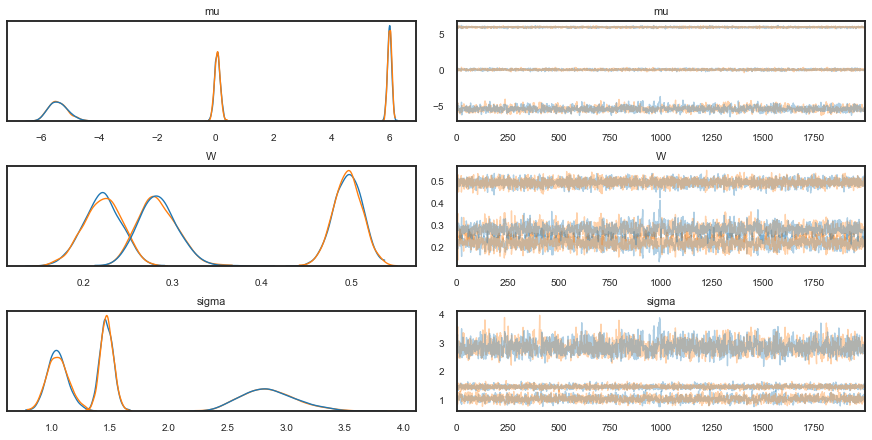

In [119]:
pm.traceplot(trace,
varnames=['mu','W','sigma'], 
lines={'mu':mus,'Ws':Ws,'sigma':sigmas}) 
plt.show()

In [233]:
az.plot_posterior(trace, var_names=['W']);

KeyError: "['W'] var names are not present in dataset"

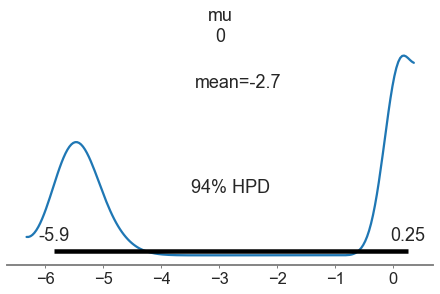

In [121]:
pm.plot_posterior(trace, var_names=['mu']);
plt.show()

In [122]:
with GMM:
    ppc_trace = pm.sample_posterior_predictive(trace, 2000)


100%|██████████| 2000/2000 [00:52<00:00, 38.20it/s]


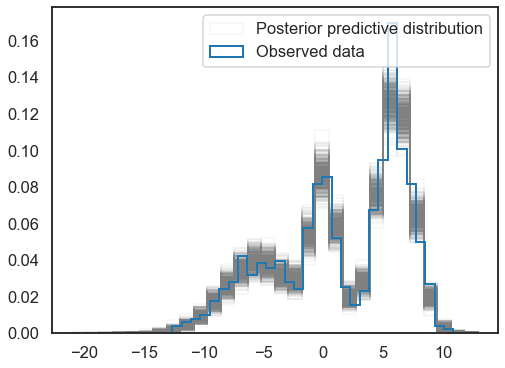

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ppc_trace['y_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['y_obs'].shape[1],
        alpha=.05,
        label='Posterior predictive distribution');

ax.hist(y, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);

In [124]:
Ws, np.mean(trace['W'][:], axis=0)

(array([0.2, 0.5, 0.3]), array([0.25180325, 0.35854524, 0.38965151]))

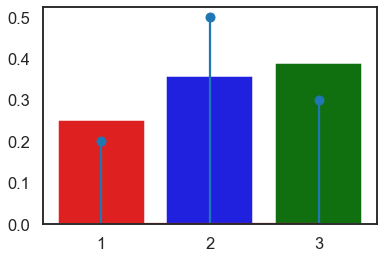

In [118]:
sns.barplot([1, 2, 3], np.mean(trace['W'][:], axis=0),palette=['red', 'blue', 'green'])
plt.stem([0, 1, 2], Ws, use_line_collection=True)

plt.show()

In [102]:
print(pm.gelman_rubin(trace,varnames=['mu','sigma','W']))

<xarray.Dataset>
Dimensions:      (W_dim_0: 3, mu_dim_0: 3, sigma_dim_0: 3)
Coordinates:
  * mu_dim_0     (mu_dim_0) int64 0 1 2
  * sigma_dim_0  (sigma_dim_0) int64 0 1 2
  * W_dim_0      (W_dim_0) int64 0 1 2
Data variables:
    mu           (mu_dim_0) float64 1.827 1.826 1.0
    sigma        (sigma_dim_0) float64 1.826 1.827 1.0
    W            (W_dim_0) float64 1.827 1.826 1.001


In [140]:
## Build list of models We want a range of models ranging from K=1 to K=3
K_range = range(3)

# Initialize lists
GMM_list = []
trace_list = []

# Specify some sampling options
draws = 2000
nchains = 1

# Loop through K_range, building model and sampling each time
for ki in K_range:
    # Add a new Model object to the list
    GMM_list += [pm.Model()]
    K = ki+1 # Here ki is the index, K is the number of groups the model assumes

    # Name each model for easy identification during comparison
    GMM_list[ki].name = '%d-Group' % K

    with GMM_list[ki]:

            # Prior over z - only applicable if K>1
            if K>1:
                    p = pm.Dirichlet('p', a=np.array([1.]*K))

                    # z is the component that the data point is being sampled from. Since we have N data points, z should be a vector with N elements.
                    z = pm.Categorical('z', p=p, shape=N)

            # Prior over the component means and standard deviations
            mu = pm.Normal('mu', mu=0., sd=10., shape=K)
            sigma = pm.HalfCauchy('sigma', beta=1., shape=K)

            # Specify the likelihood
            if K>1:
                    y_obs = pm.Normal('y_obs', mu=mu[z], sd=sigma[z], observed=y)
                    # Specify the sampling algorithms to use
                    step1 = pm.NUTS(vars=[p, mu, sigma])
                    step2 = pm.ElemwiseCategorical(vars=[z])
                    steps = [step1,step2]
            else:
                    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
                    # Specify the sampling algorithms to use - don't include z or p because they don't exist when K==1
                    step1 = pm.NUTS(vars=[mu, sigma])
                    steps = [step1]

            # Start the sampler, and save results in a new element of trace_list
            trace_list += [pm.sample(draws=draws,  step=steps)]

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1-Group_sigma, 1-Group_mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:02<00:00, 1984.82draws/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [2-Group_sigma, 2-Group_mu, 2-Group_p]
>ElemwiseCategorical: [2-Group_z]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:55<00:00, 90.81draws/s] 
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [3-Group_sigma, 3-Group_mu, 3-Group_p]
>ElemwiseCategorical: [3-Group_z]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:54<00:00, 91.61draws/s] 
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [246]:
comp_df = az.compare({'m1' : trace_list[0], 
                      'm2' : trace_list[1],
                      'm3' : trace_list[2]}, ic='WAIC')
comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m3,0,4105.31,179.569,0,1,35.0008,0,True,deviance
m2,1,5122.11,253.443,1016.8,9.12995e-210,40.3792,24.0281,True,deviance
m1,2,6162.76,1.65995,2057.45,0,44.7349,45.1028,False,deviance


In [249]:
comp_df = az.compare({'m1' : trace_list[0], 
                      'm2' : trace_list[1],
                      'm3' : trace_list[2]}, ic='LOO')
comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3,0,4704.8,479.315,0,1,34.4905,0,True,deviance
m2,1,5248.04,316.406,543.241,3.47106e-85,38.3773,45.3894,True,deviance
m1,2,6162.76,1.65989,1457.96,1.13496e-263,57.8746,64.6705,False,deviance


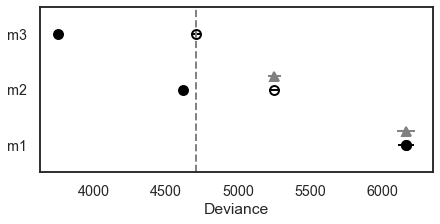

In [251]:
az.plot_compare(comp_df);

In [252]:
traces = [trace_list[0], trace_list[1],  trace_list[2]]
model_names = ['m1', 'm2', 'm10.12', 'm3']

dictionary = dict(zip(model_names, traces))

comp_df = az.compare(dictionary)

comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10.12,0,4105.31,179.569,0,1,35.4495,0,True,deviance
m2,1,5122.11,253.443,1016.8,9.89527e-208,40.7908,24.0281,True,deviance
m1,2,6162.76,1.65995,2057.45,0,46.2926,45.1028,False,deviance


In [247]:
# Convert model and trace into dictionary pairs
#dict_pairs = dict(zip(GMM_list,trace_list))

In [245]:
# # Perform WAIC (or LOO by setting ic='LOO') comparisons
# compare = pm.compare(dict_pairs, ic='WAIC')
# print(compare)